In [1]:
import pandas, os, warnings
from typing import Callable, Dict, Union
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.neighbors import NearestNeighbors
import lightgbm 
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

warnings.filterwarnings('ignore')

class Util:
    metadata_fp: str= os.path.abspath('') +\
                    "/data/train-metadata.csv"
    metadata_test_fp: str= os.path.abspath('') +\
                    "/data/test-metadata.csv"
    coefficient_of_variation: Callable[[pandas.Series], float] = \
                            lambda data: abs(data.std()/ data.mean())
    neigh= NearestNeighbors(n_neighbors=1)
    lightgbm_kwargs: Dict[str, Union[str, float, int]]={
        'objective': 'binary',
        'n_estimators': 512,
        'learning_rate': 5e-3,
        'num_leaves': 57,
        'bagging_freq': 256,
        'pos_bagging_fraction': 0.777,
        'neg_bagging_fraction': 0.077,
        'feature_fraction': 0.78,
        'random_seed': 42,
        "verbosity": -1,
        'max_depth': -1,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'boosting': 'gbdt',
        'metric': 'binary_logloss'
    }

In [2]:
metadata= pandas.read_csv(Util.metadata_fp)
metadata.drop(
    columns= ['lesion_id', 'image_type' ,'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_dnn_lesion_confidence', ## Create a DNN that replaces the confidence | then that might be a good model
                'tbp_lv_location_simple', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'copyright_license', 'iddx_full',  
                'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm', 'attribution'],
    inplace= True)

metadata_test= pandas.read_csv(Util.metadata_test_fp)
metadata_test.drop(
    columns= ['image_type' ,'tbp_tile_type', 'tbp_lv_location','tbp_lv_location_simple', 
              'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'copyright_license', 'attribution'],
    inplace= True)

In [3]:
metadata['target'].value_counts()

target
0    400666
1       393
Name: count, dtype: int64

<Axes: >

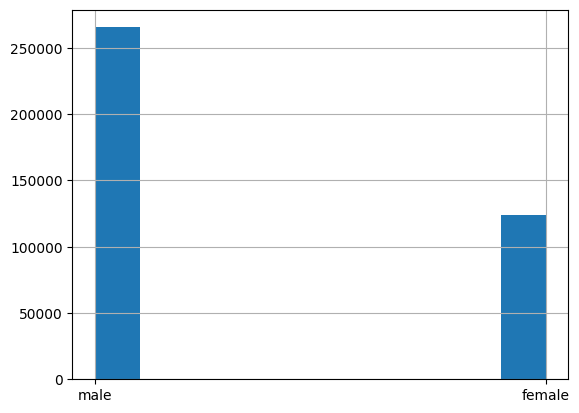

In [4]:
metadata['sex'].hist()

<Axes: >

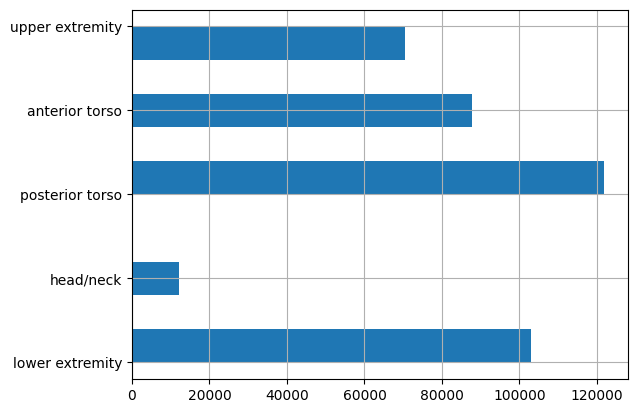

In [5]:
metadata['anatom_site_general'].hist(orientation= 'horizontal')

In [6]:
def NNImputer(df: pandas.DataFrame, columns: list[str]):
    X= df.drop(columns=columns)
    y= df[columns]

    non_nan_mask= y.notna().all(axis=1)
    X_clean= X[non_nan_mask]
    y_clean= y[non_nan_mask]

    Util.neigh.fit(X_clean)

    imputed_df= df.copy()
    for col in columns:
        nan_mask= imputed_df[col].isna()
        X_nan= X[nan_mask]

        if not X_nan.empty:
            _, indices= Util.neigh.kneighbors(X_nan)
            
            imputed_values= y_clean[col].iloc[indices.flatten()].values
            imputed_df.loc[nan_mask, col]= imputed_values
            
    return imputed_df[columns]

columns_to_impute= metadata.columns[metadata.isna().any()].tolist()
metadata[columns_to_impute]= NNImputer(metadata.drop(columns=['patient_id', 'isic_id']), columns=columns_to_impute)
del columns_to_impute

In [7]:
#metadata['age_approx']= SimpleImputer(strategy='median').fit_transform(metadata['age_approx'].values.reshape(-1, 1))
#metadata['sex']= [int(sex!= 'female') for sex in metadata['sex']]
#metadata['anatom_site_general'] = ['posterior torso' if pandas.isnull(site) else site for site in metadata['anatom_site_general']]

metadata_test['age_approx']= SimpleImputer(strategy='median').fit_transform(metadata_test['age_approx'].values.reshape(-1, 1))
metadata_test['sex']= [int(sex!= 'female') for sex in metadata_test['sex']]
metadata_test['anatom_site_general'] = ['posterior torso' if pandas.isnull(site) else site for site in metadata_test['anatom_site_general']]

In [8]:
metadata['sex']= [int(sex== 'male') for sex in metadata['sex']]
metadata= metadata.join(pandas.get_dummies(metadata['anatom_site_general']).astype(int))
metadata.drop(columns=['anatom_site_general'], inplace=True)

metadata_test= metadata_test.join(pandas.get_dummies(metadata_test['anatom_site_general']).astype(int))
metadata_test.drop(columns=['anatom_site_general'], inplace=True)

In [9]:
cv_series= Util.coefficient_of_variation(metadata.drop(
    columns=['isic_id', 'patient_id', 'target', 'sex', 'anterior torso', 'head/neck', 'lower extremity', 'posterior torso', 'upper extremity']))

robust_cols= cv_series[cv_series >= 1].index.tolist() #high variability
standard_cols= cv_series[cv_series < 1].index.tolist()

metadata[robust_cols]= StandardScaler().fit_transform(metadata[robust_cols])
metadata[standard_cols]= RobustScaler().fit_transform(metadata[standard_cols])

del robust_cols, standard_cols, cv_series

In [10]:
metadata["split"]= 0

for i, (_, valid_idx) in enumerate(StratifiedGroupKFold().split(metadata, metadata['target'], groups= metadata['patient_id'])):
    metadata.loc[valid_idx, "split"] = i

del i, valid_idx

In [11]:
import numpy as np 
def comp_score(solution: pandas.DataFrame, submission: pandas.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

In [12]:
for split in metadata['split'].unique():
    lgbm= lightgbm.LGBMClassifier(**Util.lightgbm_kwargs)

    metadata_train= metadata[metadata['split']!= split].reset_index(drop=True)
    lgbm.fit(metadata_train.drop(columns=['isic_id', 'patient_id', 'target']), metadata_train['target'])

    metadata_valid= metadata[metadata['split']== split].reset_index(drop=True)
    predictions= lgbm.predict_proba(metadata_valid.drop(columns=['isic_id', 'patient_id', 'target']))[:, 1]
    
    score = comp_score(metadata_valid["target"], pandas.DataFrame(predictions, columns=["prediction"]), "")
    
    print(f"split: {split} - Partial AUC Score: {score:.5f}")
    del lgbm, score, split, metadata_valid, metadata_train

split: 4 - Partial AUC Score: 0.15621
split: 2 - Partial AUC Score: 0.17001
split: 1 - Partial AUC Score: 0.14833
split: 0 - Partial AUC Score: 0.15609
split: 3 - Partial AUC Score: 0.14075


In [19]:
metadata

,isic_id,target,patient_id,age_approx,sex,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,...,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,anterior torso,head/neck,lower extremity,posterior torso,upper extremity,split
0,ISIC_0015670,0,IP_1235828,0.00,1,-0.214286,0.088969,0.331669,-0.180169,-0.471027,...,-0.074578,0.700479,1.806510,-0.055556,0,0,1,0,0,4
1,ISIC_0015845,0,IP_8170065,0.00,1,-1.474026,2.394676,2.281941,-0.265477,-0.369083,...,-0.660788,2.530633,0.020034,-0.388889,0,1,0,0,0,2
2,ISIC_0015864,0,IP_6724798,0.00,1,0.019481,0.557706,0.517252,1.413358,1.163229,...,-0.219546,-0.285606,0.466653,0.166667,0,0,0,1,0,4
3,ISIC_0015902,0,IP_4111386,0.25,1,-0.097403,-1.117772,-0.546161,-0.969763,-0.956885,...,-0.459938,-0.826794,-0.426251,0.444444,1,0,0,0,0,1
4,ISIC_0024200,0,IP_8313778,-0.25,1,-0.415584,0.989908,1.144856,-0.246164,-0.169973,...,-0.050191,0.474741,0.182516,-0.777778,1,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,0.50,1,2.227273,0.557405,0.049435,-0.073317,0.011220,...,2.412357,0.028189,0.038825,0.111111,1,0,0,0,0,1
401055,ISIC_9999951,0,IP_5678181,0.00,1,-0.168831,0.035331,0.281298,0.863583,0.739081,...,-0.152226,1.092327,1.041675,-0.722222,0,0,0,1,0,1
401056,ISIC_9999960,0,IP_0076153,0.25,0,-0.857143,-0.496469,-0.503388,0.241417,-0.034574,...,-0.239777,0.079681,-0.581487,-0.555556,1,0,0,0,0,1
401057,ISIC_9999964,0,IP_5231513,-1.50,0,-0.370130,0.499951,-1.103220,0.037448,0.053251,...,0.740082,-0.276448,-0.706045,0.555556,1,0,0,0,0,1


In [25]:
df= metadata.drop(columns=['split'])

In [52]:
df.to_csv('tempMetadata.csv')

In [60]:
df.isnull().sum()

isic_id                        0
target                         0
patient_id                     0
age_approx                     0
sex                            0
clin_size_long_diam_mm         0
tbp_lv_A                       0
tbp_lv_Aext                    0
tbp_lv_B                       0
tbp_lv_Bext                    0
tbp_lv_C                       0
tbp_lv_Cext                    0
tbp_lv_H                       0
tbp_lv_Hext                    0
tbp_lv_L                       0
tbp_lv_Lext                    0
tbp_lv_areaMM2                 0
tbp_lv_area_perim_ratio        0
tbp_lv_color_std_mean          0
tbp_lv_deltaA                  0
tbp_lv_deltaB                  0
tbp_lv_deltaL                  0
tbp_lv_deltaLB                 0
tbp_lv_deltaLBnorm             0
tbp_lv_eccentricity            0
tbp_lv_minorAxisMM             0
tbp_lv_nevi_confidence         0
tbp_lv_norm_border             0
tbp_lv_norm_color              0
tbp_lv_perimeterMM             0
tbp_lv_rad